## 1. 시계열 데이터에 대한 RNN 적용

In [ ]:
import pandas as pd
data=pd.read_csv('AMZN.csv', header=0,index_col="Date")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2019-04-17 to 2020-04-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8+ KB


In [ ]:
print(data.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-04-17  1872.989990  1876.469971  1860.439941  1864.819946  1864.819946   
2019-04-18  1868.790039  1870.819946  1859.479980  1861.689941  1861.689941   
2019-04-22  1855.400024  1888.420044  1845.640015  1887.310059  1887.310059   
2019-04-23  1891.199951  1929.260010  1889.579956  1923.770020  1923.770020   
2019-04-24  1925.000000  1929.689941  1898.160034  1901.750000  1901.750000   

             Volume  
Date                 
2019-04-17  2893500  
2019-04-18  2749900  
2019-04-22  3373800  
2019-04-23  4640400  
2019-04-24  3675800  


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,1864.800556,1883.242064,1846.651429,1866.393093,1866.393093,4.060800e+06
std,110.513502,116.543016,110.148293,114.338644,114.338644,2.035731e+06
min,1641.510010,1725.000000,1626.030029,1676.609985,1676.609985,8.813000e+05
25%,1778.007507,1793.577515,1762.510040,1783.422516,1783.422516,2.748850e+06
50%,1842.005005,1870.639954,1826.875000,1854.284973,1854.284973,3.410900e+06
75%,1921.224945,1936.729981,1898.567535,1912.812469,1912.812469,4.754375e+06
max,2346.000000,2461.000000,2335.000000,2408.189941,2408.189941,1.556730e+07


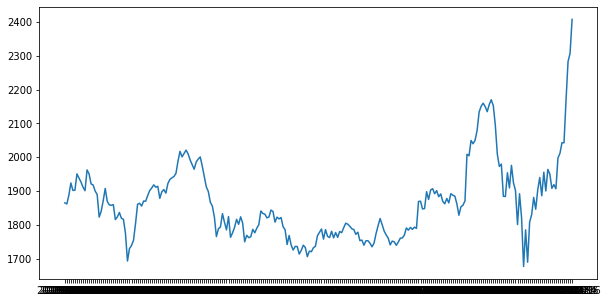

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(data['Close'])
plt.show()

- 정상성(Stationarity)
 - RNN이나 좋은 기법이라 하더라도 시계열 자료가 정상성이 결여된 경우 성능이 좋지 않을 수 있음
 - 정상성이란: 시계열 자료가 뚜렷한 트렌드 없이 값의 변동이 시간의 흐름에 따라 일정, stationarity
 - 정상성 여부의 검정: Dickey Fuller의 단위근 검정
  - 귀무가설: 비정상시계열 (단위근 있다)
  - 대립가설: 정상시계열(단위근 없다)

 - 비정상시계열인 경우: 시계열 자료 차분(differencing)하여 정상시계열로 변환 후 피팅

 - 주가: 일반적으로 비정상 시계열, 로그수익율인 경우 정상시계열이 됨
 - 수익율 = 현재 가격/과거 가격
 - 로그수익율: log현재가격-log과거가격 = log(현재가격/과거가격)


In [ ]:
#!pip install statsmodels
from statsmodels.tsa.stattools import adfuller    #종가의 정상성 여부 점검
result=adfuller(data['Close'])
print(result) #0.5933이 p-value, 비정상 시계열

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(-1.3767742252801602, 0.5933588180241118, 9, 242, {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}, 2330.001481538131)


- acf, pacf
 - acf: 자기상관함수, autocorrelation function
 - pacf: 편자기상관함수, partial autocorrelation function

 - p가 증가 시, 지수적 감소 혹은 절단 형태여야 정상성, 둘 중 하나라도 느리게 감소하거나 증가 시 비정상성

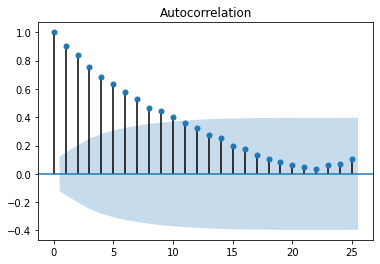

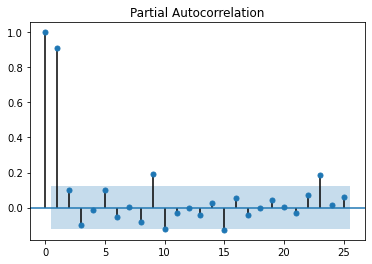

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close']) #느리게 감소, 비정상시계열
plot_pacf(data['Close'])
plt.show()

             Open        High         Low       Close   Adj Close      Volume
count  251.000000  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.000897    0.001080    0.000905    0.001019    0.001019    0.005657
std      0.020894    0.016299    0.017545    0.019030    0.019030    0.347770
min     -0.075945   -0.058493   -0.072806   -0.082535   -0.082535   -0.970373
25%     -0.008895   -0.006549   -0.007209   -0.007880   -0.007880   -0.209841
50%      0.000475    0.000223    0.001132    0.000514    0.000514   -0.025878
75%      0.009870    0.007017    0.008136    0.008992    0.008992    0.200873
max      0.099056    0.093154    0.078766    0.071196    0.071196    1.919016


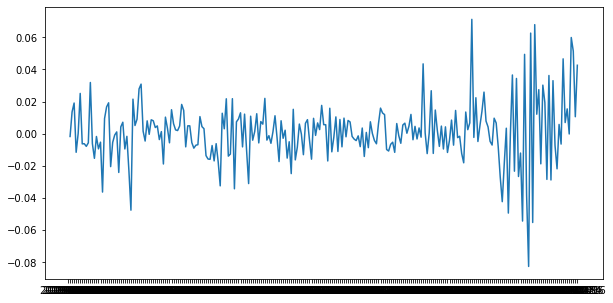

In [ ]:
import numpy as np
datapct=data.pct_change()
logreturn=np.log(1+datapct) #로그수익율
logreturn.head()
print(logreturn.describe())
plt.figure(figsize=(10,5))
plt.plot(logreturn['Close'])
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
logreturn=logreturn.dropna()
result=adfuller(logreturn['Close']) #p-value < 0.05
print(result)

(-3.656873938146206, 0.00476231659749063, 8, 242, {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}, -1210.8538494804302)


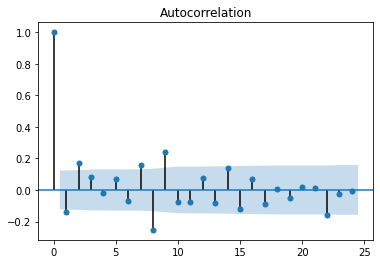

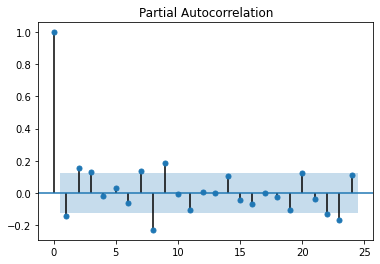

<class 'pandas.core.frame.DataFrame'>


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(logreturn['Close'])  
plot_pacf(logreturn['Close']) #그림에서 절단이 일어나는 위치를 p의 값으로 지정, 14?
plt.show()
print(type(logreturn))

In [ ]:
logr1=logreturn['Close'].values
print(type(logr1))
print(logr1.shape)
logr=logr1.reshape(1,-1)
print(logr.shape)
inte=24
x=[]
y=[]
for i in range(logr.shape[1]):
    if i+inte>logr.shape[1]-1:
        break
    else:
         xx=logr[0,i:i+inte]
         x.append(xx)
         yy=logr[0,i+inte]
         y.append(yy)
print(type(x))
print(type(y))
x=np.array(x)
y=np.array(y)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)
x_train=x[:210]
x_test=x[210:]
y_train=y[:210]
y_test=y[210:]

<class 'numpy.ndarray'>
(251,)
(1, 251)
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(227, 24)
(227,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
from tensorflow.keras import regularizers
model=Sequential()
model.add(Dense(1,input_shape=(24,))) #p=24, AR(14)모형과 동일, 14개의 x변수를 갖는 셈.
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 1s 3ms/step - loss: 7.2261e-04 - mae: 0.0195
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 6.9110e-04 - mae: 0.0190
Epoch 3/30
7/7 [==============================] - 0s 2ms/step - loss: 6.7470e-04 - mae: 0.0188
Epoch 4/30
7/7 [==============================] - 0s 2ms/step - loss: 6.6424e-04 - mae: 0.0186
Epoch 5/30
7/7 [==============================] - 0s 2ms/step - loss: 6.5516e-04 - mae: 0.0185
Epoch 6/30
7/7 [==============================] - 0s 2ms/step - loss: 6.4372e-04 - mae: 0.0184
Epoch 7/30
7/7 [==============================] - 0s 2ms/step - loss: 6.3657e-04 - mae: 0.0182
Epoch 8/30
7/7 [==============================] - 0s 2ms/step - loss: 6.2363e-04 - mae: 0.0180
Epoch 9/30
7/7 [==============================] - 0s 2ms/step - loss: 6.1392e-04 - mae: 0.0179
Epoch 10/30
7/7 [==============================] - 0s 2ms/step - loss: 6.0512e-04 - mae: 0.0177
Epoch 11/30
7/7 [==============================] 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
model=Sequential()
model.add(Dense(64,activation='relu',input_shape=(24,)))
model.add(Dense(1))                

model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 0s 2ms/step - loss: 4.5610e-04 - mae: 0.0149
Epoch 2/30
7/7 [==============================] - 0s 2ms/step - loss: 3.5118e-04 - mae: 0.0129
Epoch 3/30
7/7 [==============================] - 0s 2ms/step - loss: 3.1066e-04 - mae: 0.0120
Epoch 4/30
7/7 [==============================] - 0s 2ms/step - loss: 2.8949e-04 - mae: 0.0117
Epoch 5/30
7/7 [==============================] - 0s 2ms/step - loss: 2.6636e-04 - mae: 0.0112
Epoch 6/30
7/7 [==============================] - 0s 2ms/step - loss: 2.4749e-04 - mae: 0.0107
Epoch 7/30
7/7 [==============================] - 0s 2ms/step - loss: 2.6094e-04 - mae: 0.0114
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 2.2651e-04 - mae: 0.0107
Epoch 9/30
7/7 [==============================] - 0s 2ms/step - loss: 2.1639e-04 - mae: 0.0106
Epoch 10/30
7/7 [==============================] - 0s 2ms/step - loss: 2.1135e-04 - mae: 0.0105
Epoch 11/30
7/7 [==============================] 

In [ ]:
x_train=x_train.reshape(-1,1,24)
x_test=x_test.reshape(-1,1,24)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM  #(sample, timestep, features 형태의 데이터)
model=Sequential()
model.add(LSTM(32, input_shape=(1,24)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 3s 4ms/step - loss: 3.4364e-04 - mae: 0.0128
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 3.2421e-04 - mae: 0.0126
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 3.2439e-04 - mae: 0.0123
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 3.0963e-04 - mae: 0.0121
Epoch 5/30
7/7 [==============================] - 0s 3ms/step - loss: 3.0722e-04 - mae: 0.0122
Epoch 6/30
7/7 [==============================] - 0s 3ms/step - loss: 3.1562e-04 - mae: 0.0124
Epoch 7/30
7/7 [==============================] - 0s 3ms/step - loss: 2.9952e-04 - mae: 0.0120
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 2.9509e-04 - mae: 0.0119
Epoch 9/30
7/7 [==============================] - 0s 3ms/step - loss: 2.9369e-04 - mae: 0.0117
Epoch 10/30
7/7 [==============================] - 0s 3ms/step - loss: 2.8873e-04 - mae: 0.0118
Epoch 11/30
7/7 [==============================] 

In [ ]:
model=Sequential()
model.add(GRU(32, input_shape=(1,24)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 3ms/step - loss: 4.1947e-04 - mae: 0.0147
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 3.1703e-04 - mae: 0.0129
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 3.0645e-04 - mae: 0.0124
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 3.0161e-04 - mae: 0.0124
Epoch 5/30
7/7 [==============================] - 0s 3ms/step - loss: 2.9015e-04 - mae: 0.0123
Epoch 6/30
7/7 [==============================] - 0s 3ms/step - loss: 3.1528e-04 - mae: 0.0128
Epoch 7/30
7/7 [==============================] - 0s 3ms/step - loss: 2.9671e-04 - mae: 0.0123
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 2.7591e-04 - mae: 0.0119
Epoch 9/30
7/7 [==============================] - 0s 3ms/step - loss: 3.0001e-04 - mae: 0.0127
Epoch 10/30
7/7 [==============================] - 0s 4ms/step - loss: 2.7715e-04 - mae: 0.0121
Epoch 11/30
7/7 [==============================] 